# Detect structure in quasicrystal patterns

To show complex graphics, you may need to strat Jupyter with this command

    jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [89]:
%matplotlib inline

from numpy import *
from matplotlib.pylab import *
import scipy
import scipy.spatial
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
from neurotools.plot import *
import neurotools.plot
from neurotools.nlab import *
plt.set_cmap('viridis')

# Render quasicrystal as sum of plane waves

In [99]:
K  = 220*2  # frequency of waves. Higher = more
N  = 4000 # size of domain for rasterizing
M  = 11   # number of waves

# Generate grid
x  = linspace(-1,1,N)
y  = linspace(-1,1,N)
xy = x[:,None] + 1j*y[None,:]

(1+0j)
(0.959492973614+0.281732556841j)
(0.841253532831+0.540640817456j)
(0.654860733945+0.755749574354j)
(0.415415013002+0.909631995355j)
(0.142314838273+0.989821441881j)
(-0.142314838273+0.989821441881j)
(-0.415415013002+0.909631995355j)
(-0.654860733945+0.755749574354j)
(-0.841253532831+0.540640817456j)
(-0.959492973614+0.281732556841j)


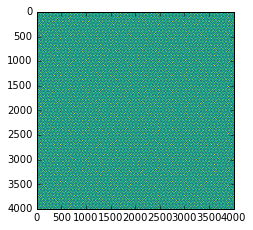

In [100]:
phases = ones(M)*pi*0
rotation = exp(linspace(0,pi,M+1)[:M]*1j)
xyr = array(xy)*0
for p,rr in zip(phases,rotation):
    print(rr)
    xyr += cos(real(xy*rr)*K+p)
qq = xyr#-xyr**2
qq = real(-qq)
subplot(131)
imshow(qq)

# Detect local maxima

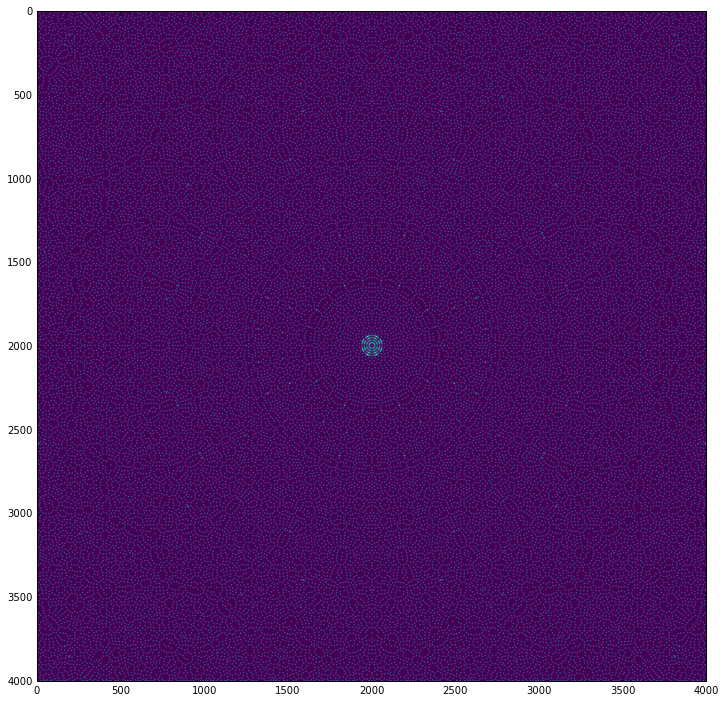

In [101]:
from scipy.ndimage.filters import maximum_filter

peaks = float32((maximum_filter(qq,3)==qq) | (maximum_filter(-qq,3)==-qq))
imshow(scipy.ndimage.gaussian_filter(peaks,3))

## Convert local maxima to point graph

In [102]:
from collections import defaultdict

def z2xy(z):
    '''
    Converts an array of complex numbers into two arrays
    representing real and imaginary parts, respectively.
    '''
    return real(z),imag(z)

def uniquerow(x):
    '''
    Removes duplicate rows from a 2D numpy array
    '''
    return array(list(set(map(tuple,x))))

def trianglesToEdges(triangles):
    '''
    Accepts Ntriangles x 3 array of triangle indeces, like the format
    returned by `scipy.spatial.Delaunay(...).simplices`. Returns a
    Nedges x 2 numpy array of unique edges in the triangulation
    '''
    tedges    = triangles[:,[0,1,1,2,2,0]].reshape((size(triangles),2))
    tedges    = uniquerow(sort(tedges,axis=1))
    return tedges

def edgesNearby(iz,microd):
    '''
    Returns a dictionary mapping from 
    indecies into point list iz 
    (2d locations passed as x+iy complex)
    to a list of nearby point indices
    
    Computed by thresholding delaunay triangulation
    '''
    points    = array([real(iz),imag(iz)])
    triangles = scipy.spatial.Delaunay(points.T).simplices
    tedges    = trianglesToEdges(triangles)
    edgelen   = ravel(abs(diff(iz[tedges],axis=1)))
    tedges    = tedges[edgelen<microd,:]
    
    #tedges = concatenate([tedges,tedges[:,[1,0]]])
    #coordsparse = scipy.sparse.coo_matrix((ones(tedges.shape[0]),(tedges[:,0],tedges[:,1])))
    #edgelist = scipy.sparse.csr_matrix(coordsparse)
    
    edgelist  = defaultdict(set)
    for i,z in enumerate(iz):
        edgelist[i] = tuple(ravel(tedges[(tedges==i)[:,[1,0]]]))   
    
    return edgelist

def coalesce(iz,edgelist):
    '''
    Joint connected components as defined in edgelist, and return the centroids
    taken as an average of all point locations in list iz 
    (2d locations passed as x+iy complex)
    '''
    components = {}
    for i in arange(len(iz)):
        components[i]=i
        for e in edgelist[i]:
        #for e in scipy.sparse.find(edgelist[i])[1]:
            if e in components:
                components[i]=components[e]
                break
    componentlist = defaultdict(set)
    for e,cid in components.items():
        componentlist[cid]|={e}
    component_ids = sorted(list(set(components.values())))
    centroids = array([mean(iz[array(list(componentlist[cid]))]) for cid in component_ids])
    return centroids

def plot_edges(iz,edges,**kwargs):
    '''
    Plots a set of edges given by 2d complex numbers and Nedges x 2 array of edge indices
    keword arguments are forwarded to matplotlib.plot
    '''
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()
    
def plot_triangles(iz,triangles,**kwargs):
    '''
    '''
    edges = trianglesToEdges(triangles)
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()

In [103]:
iz = xy[peaks>0.1]

In [104]:
microd = 7.0/K/M
rotation  = exp(linspace(-pi,pi,2*M+1)[:2*M]*1j)
centroids = coalesce(iz,edgesNearby(iz,microd))
'''centroids = np.concatenate([centroids,conj(centroids)])
centroids = coalesce(centroids,edgesNearby(centroids,microd))
centroids = ravel(centroids[:,None]*rotation[None,:])
centroids = coalesce(centroids,edgesNearby(centroids,microd))'''

'centroids = np.concatenate([centroids,conj(centroids)])\ncentroids = coalesce(centroids,edgesNearby(centroids,microd))\ncentroids = ravel(centroids[:,None]*rotation[None,:])\ncentroids = coalesce(centroids,edgesNearby(centroids,microd))'

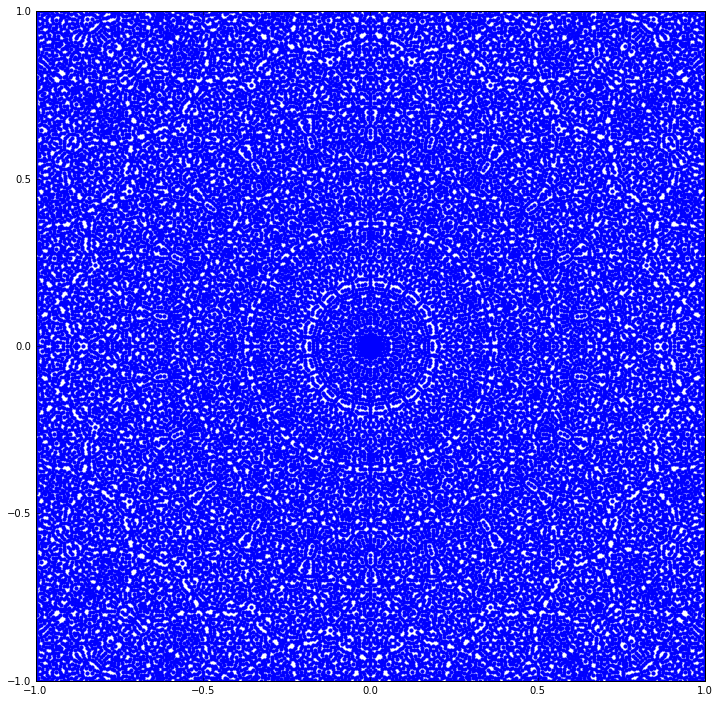

In [105]:
centroids = array(centroids)
points = array([real(centroids),imag(centroids)])
scatter(*points,s=10,color='b')
xlim(-1,1)
ylim(-1,1)
force_aspect()

In [106]:
from scipy.spatial import Voronoi, voronoi_plot_2d
points = array([real(centroids),imag(centroids)])
vor = Voronoi(points.T,qhull_options="Qc")
vor.regions
vor.point_region
v = vor.vertices
v = v[:,0]+1j*v[:,1]
ok = array([(all(array(i)>=0)) for i in vor.regions])
r  = array( vor.regions)[ok]
nc = array([mean(v[rr]) for rr in r])

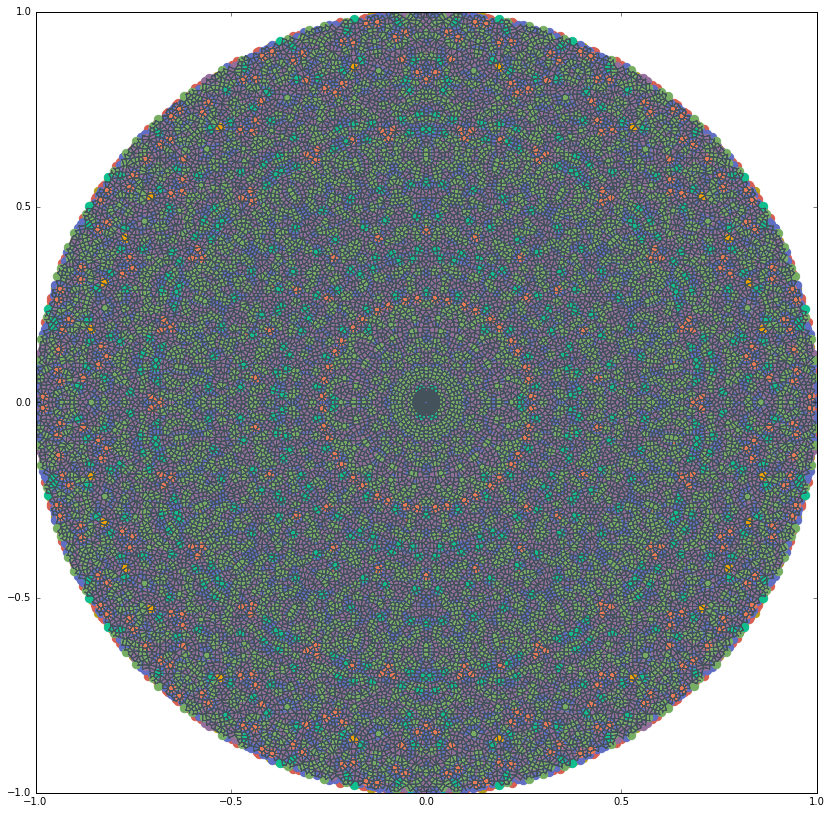

In [107]:
figure(figsize=(14,14))

ee = concatenate([array(list(zip(array(e)[arange(-1,len(e))],e))) for e in r])
vmask = array(v)
inbounds = abs(v)>1
vmask[inbounds] = NaN
plot_edges(vmask,ee,color=BLACK,lw=1)
degree = array(list(map(len,r)))

'''for c,reg in zip(nc,r):
    if abs(c)<1:
        text(real(c),imag(c),str(len(reg)),horizontalalignment='center',
          verticalalignment='center')
'''
colors = GATHER[1:-1] + [neurotools.plot.CHARTREUSE, neurotools.plot.CRIMSON, 
                         neurotools.plot.INDEGO, neurotools.plot.MAUVE, 
                         neurotools.plot.MOSS, neurotools.plot.VERIDIAN]
inbounds = abs(nc)<1
for i in range(2,M*4+1):
    scatter(*z2xy(nc[inbounds][degree[inbounds]==i].T),s=70,color=colors[i%len(colors)])
xlim(-1,1)
ylim(-1,1)
force_aspect()

show()